In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns
from src.models.lr import predict_mean_returns
from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

from src.models.rnn import _train_rnn_model, predict_mean_returns_rnn
from src.models.lr import create_features 




# User input

In [2]:
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2010-01-01"
end_date = "2025-01-01" 

window = 24

alpha_blend = 0.3 # 0.0 means no correction in the mean

# MODEL_MACHINE_LEARNING = 'LinearRegression'
MODEL_MACHINE_LEARNING = 'MLPRegressor'

# Load data and modeling

In [3]:
prices = load_prices(tickers, start=start_date, end=end_date)

c:\Users\leomc\OneDrive\Work\Unicap\Semestre 2025.2\TCC2\git\deep_learning_finance\src\data\loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [4]:

print(prices.shape)
returns = compute_returns(prices, freq='monthly')

(3722, 9)


In [5]:
returns

Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,
2010-02-28,-0.005800,-0.069914,0.076227,-0.009336,0.001578,0.021072,0.012877,0.031486,-0.021606
2010-03-31,-0.065054,0.017981,0.009591,0.000469,0.000000,0.068844,0.022537,0.132805,0.078453
2010-04-30,0.065855,-0.044850,0.004690,0.000470,0.000000,-0.033035,-0.066199,-0.064274,-0.065790
2010-05-31,0.001224,0.060357,-0.120863,0.000469,-0.010240,-0.079282,-0.090969,-0.058380,-0.042253
2010-06-30,0.059064,-0.043693,-0.051193,0.006021,-0.056400,-0.063076,-0.092567,-0.127000,-0.014775
...,...,...,...,...,...,...,...,...,...
2024-08-31,0.110535,0.168664,0.076678,0.260146,0.009106,0.083799,0.082343,0.002053,0.072930
2024-09-30,0.017107,-0.148119,-0.027105,-0.058958,0.043716,-0.008205,-0.085344,0.065962,0.005689
2024-10-31,-0.033639,-0.008403,-0.031273,-0.007853,-0.041885,-0.029711,-0.002777,-0.022831,-0.005148


In [6]:
# LR predictions (penultima janela)
pred_montlhy, split_idx, pure_montlhy, cov_montlhy  = predict_mean_returns(returns, window=window, alpha_blend=alpha_blend, model_machine_learning=MODEL_MACHINE_LEARNING) 

Ativo: ABEV3.SA - Retorno Médio Previsto: 0.017211 - Retorno Médio Real: 0.009221.
Ativo: B3SA3.SA - Retorno Médio Previsto: 0.035501 - Retorno Médio Real: 0.008693.
Ativo: BBAS3.SA - Retorno Médio Previsto: 0.020500 - Retorno Médio Real: 0.014830.
Ativo: BBDC4.SA - Retorno Médio Previsto: 0.021538 - Retorno Médio Real: 0.007723.
Ativo: GGBR4.SA - Retorno Médio Previsto: 0.020462 - Retorno Médio Real: 0.009891.
Ativo: ITUB4.SA - Retorno Médio Previsto: 0.021267 - Retorno Médio Real: 0.010707.
Ativo: PETR4.SA - Retorno Médio Previsto: 0.020846 - Retorno Médio Real: 0.015880.
Ativo: VALE3.SA - Retorno Médio Previsto: 0.035549 - Retorno Médio Real: 0.010034.
Ativo: WEGE3.SA - Retorno Médio Previsto: 0.042990 - Retorno Médio Real: 0.021661.


In [7]:
pure_montlhy

Ticker
ABEV3.SA    0.008763
B3SA3.SA    0.022914
BBAS3.SA    0.015297
BBDC4.SA    0.013160
GGBR4.SA    0.013956
ITUB4.SA    0.012935
PETR4.SA    0.012944
VALE3.SA    0.015533
WEGE3.SA    0.029889
dtype: float64

In [8]:
pred_montlhy

ABEV3.SA    0.017211
B3SA3.SA    0.035501
BBAS3.SA    0.020500
BBDC4.SA    0.021538
GGBR4.SA    0.020462
ITUB4.SA    0.021267
PETR4.SA    0.020846
VALE3.SA    0.035549
WEGE3.SA    0.042990
Name: Predicted_Mean_Returns, dtype: float64

# Rodar Markowitz para cada modelo

In [9]:
models = [
    {
        "name": "Markowitz Puro - 30% TESTES FUTURO",
        "mean_returns": pure_montlhy,
        "cov": cov_montlhy,
        "color": "blue",
        "linestyle": "-",
    },
    {
        "name": "Markowitz com Regressão Linear - 30% TESTES FUTURO",
        "mean_returns": pred_montlhy,
        "cov": cov_montlhy,
        "color": "orange",
        "linestyle": "--",
    },
]

# Solve Markowitz once

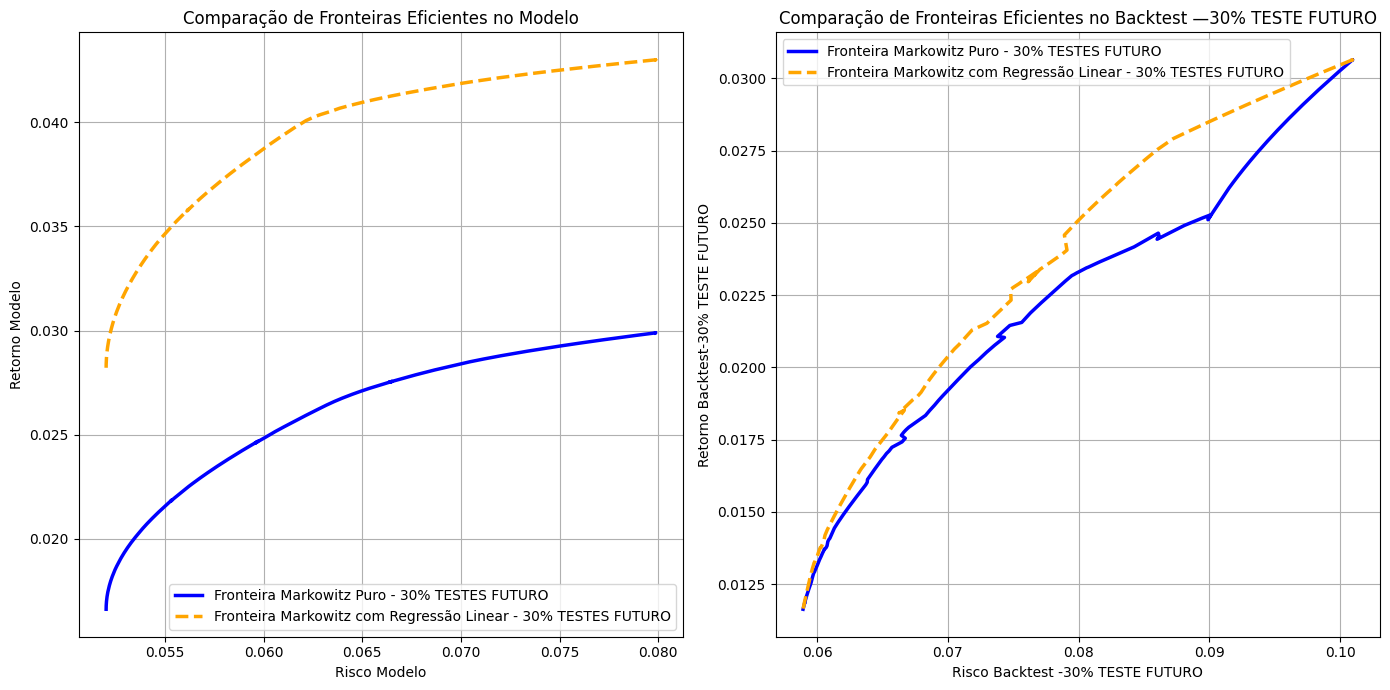

In [10]:
ret_curve, vol_curve, lambdas, w_list = compare_frontiers(models, window=window, returns_monthly=returns, split_idx=split_idx)

In [11]:
from outputs.charts.markowitz_plot import (
    find_lambda_for_risk,
    solve_markowitz,
    portfolio_volatility,
    portfolio_return
)
from src.optimization.markowitz import solve_markowitz, portfolio_return, portfolio_volatility

# from src.data.loader import load_prices, compute_returns
# from src.models.lr import predict_mean_returns
# from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
# from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

def compare_time_series_local(
    models: list,
    target_risk: float = 0.014,
    w_list: list = None,
    lambdas: list = None,
    ret_curve: list = None,
    vol_curve: list = None,
):
    """
    Compara o crescimento acumulado mensal de N modelos.

    Cada item de 'models':
    {
        "name": str,
        "mean_returns": pd.Series,
        "cov": pd.DataFrame,
        "color": str,
        "linestyle": str
    }
    """

    plt.figure(figsize=(14, 8))
    counter = 0
    for model in models:

        name = model["name"]
        mean = model["mean_returns"]
        cov = model["cov"]


        lamb = None
        min_diff = 10e10
        for i, lambd in enumerate(lambdas):
            if np.abs(vol_curve[counter][i] - target_risk) <= min_diff:
                min_diff = np.abs(vol_curve[counter][i] - target_risk)
                lamb = lambd


        index_lamb = lambdas.tolist().index(lamb)
        weights = w_list[counter][index_lamb]


        port = returns[split_idx:].dot(weights)

        print("Lambda {}, Name: {}, Volatility: {:.4f}, Mean Return: {:.4f}".format(lamb, name, port.std(), port.mean()   ))

        # print("Actual mean return: {}".format(portfolio_return(weights, port.mean() )))

        # port = returns[split_idx:].dot(weights)
        # print("Actual return: {}".format(port.mean())) 


        acum = (1 + returns[split_idx:].dot(weights)).cumprod()
        plt.plot(
            acum.index, acum,
            # acum.index, acum,
            label=name,
            linewidth=2,
            color=model["color"],
            linestyle=model["linestyle"],
            # marker='o', markersize=5
        )
        counter += 1

    plt.title("Comparação Temporal dos Portfólios (Backtest). Target Risk: {:.4f}".format(target_risk))
    plt.xlabel("Tempo (Mensal)")
    plt.ylabel("Crescimento Acumulado")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
np.min( [np.min(vol_curve[0]), np.min(vol_curve[1])]  )

np.float64(0.052014252871965524)

In [13]:
min_risk = np.max( [np.min(vol_curve[0]), np.min(vol_curve[1])]  )
max_risk = np.min( [np.max(vol_curve[0]), np.max(vol_curve[1])]  )

Lambda 1.0, Name: Markowitz Puro - 30% TESTES FUTURO, Volatility: 0.0589, Mean Return: 0.0116
Lambda 1.0, Name: Markowitz com Regressão Linear - 30% TESTES FUTURO, Volatility: 0.0589, Mean Return: 0.0116


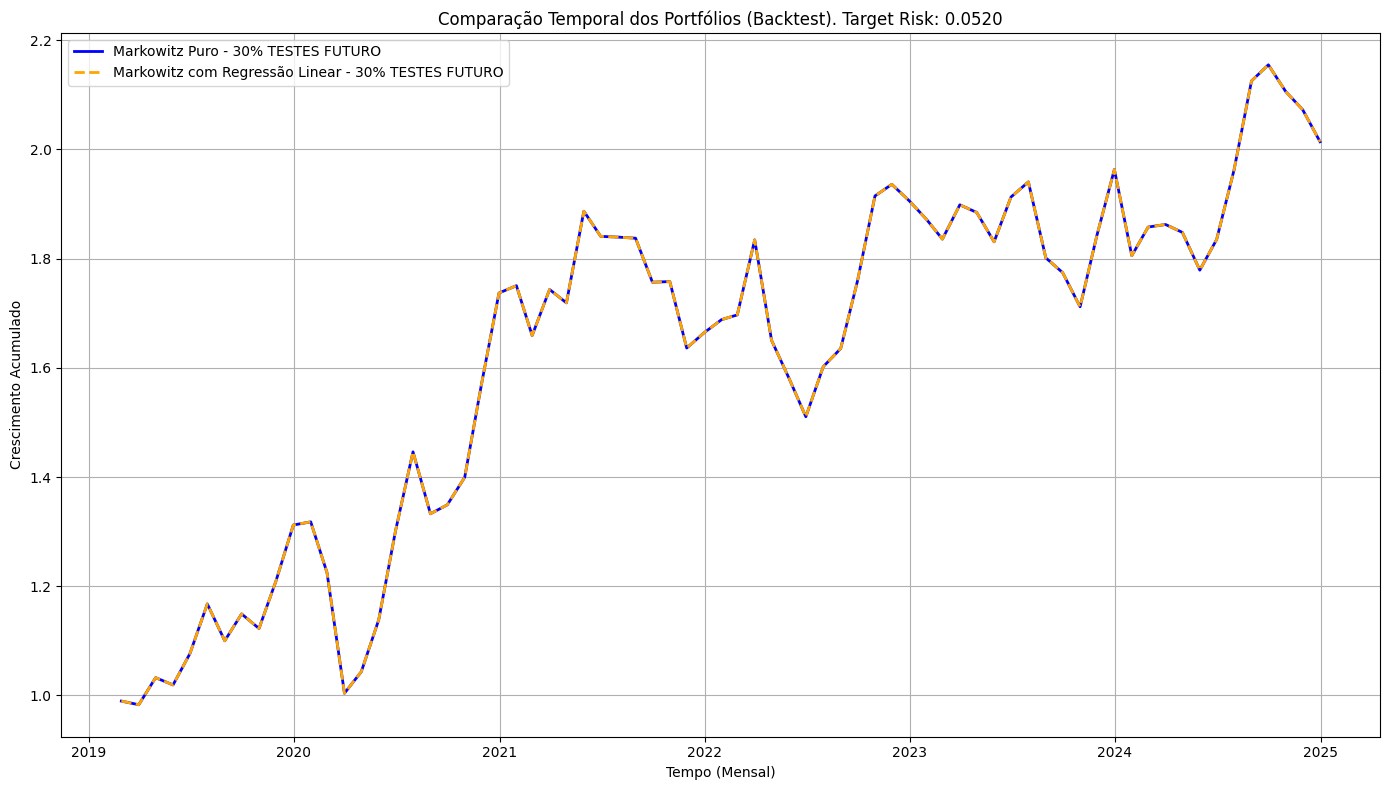

Lambda 0.365, Name: Markowitz Puro - 30% TESTES FUTURO, Volatility: 0.0730, Mean Return: 0.0205
Lambda 0.41500000000000004, Name: Markowitz com Regressão Linear - 30% TESTES FUTURO, Volatility: 0.0705, Mean Return: 0.0206


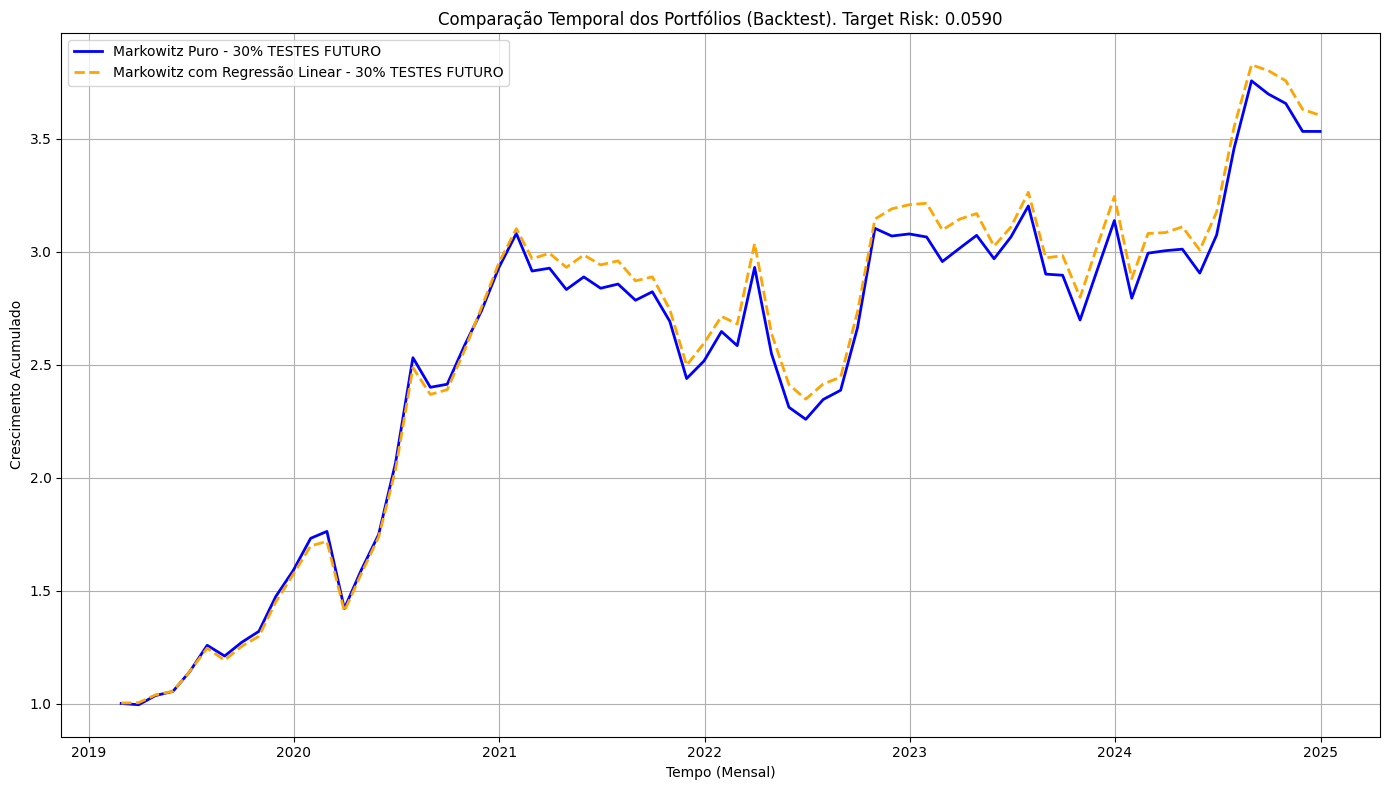

Lambda 0.20500000000000002, Name: Markowitz Puro - 30% TESTES FUTURO, Volatility: 0.0860, Mean Return: 0.0244
Lambda 0.17, Name: Markowitz com Regressão Linear - 30% TESTES FUTURO, Volatility: 0.0821, Mean Return: 0.0260


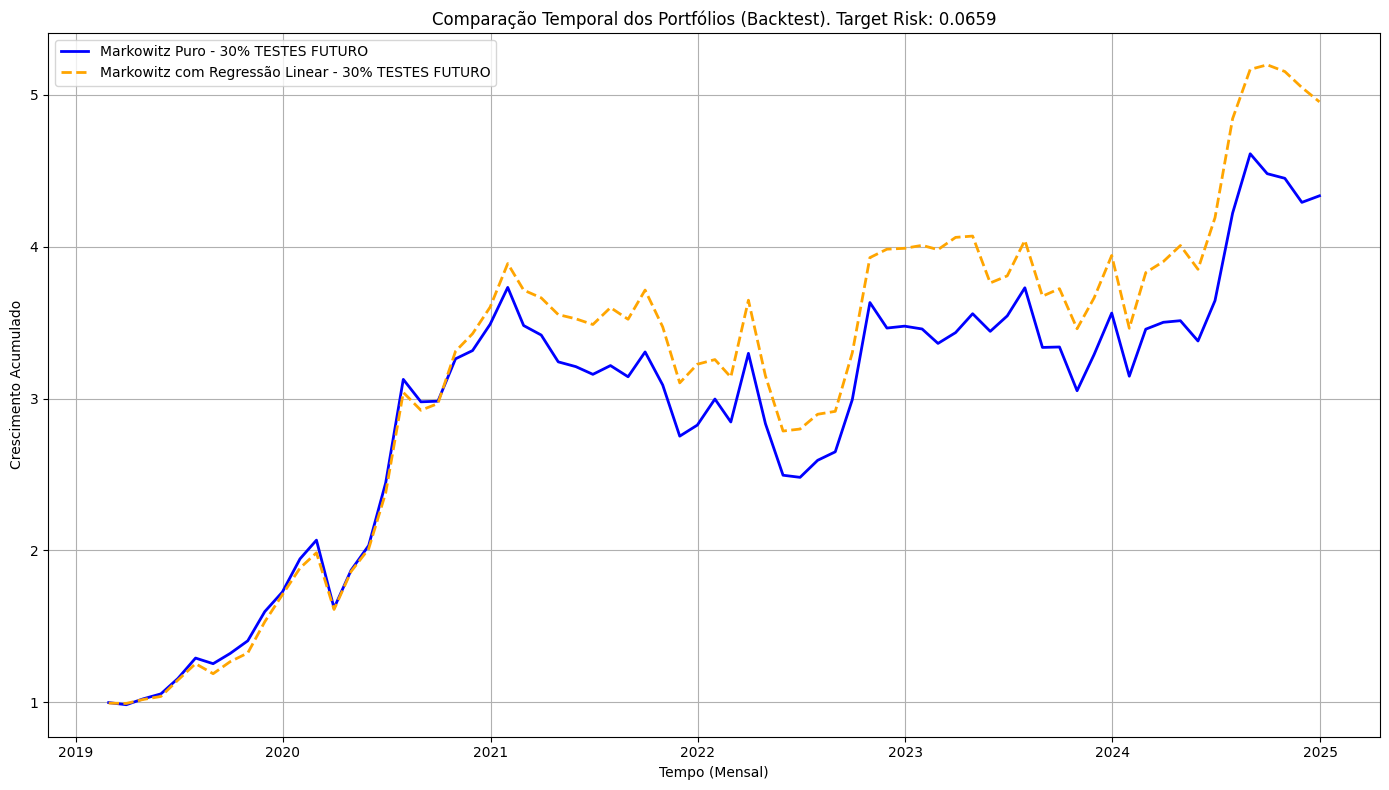

Lambda 0.14, Name: Markowitz Puro - 30% TESTES FUTURO, Volatility: 0.0937, Mean Return: 0.0274
Lambda 0.11, Name: Markowitz com Regressão Linear - 30% TESTES FUTURO, Volatility: 0.0912, Mean Return: 0.0288


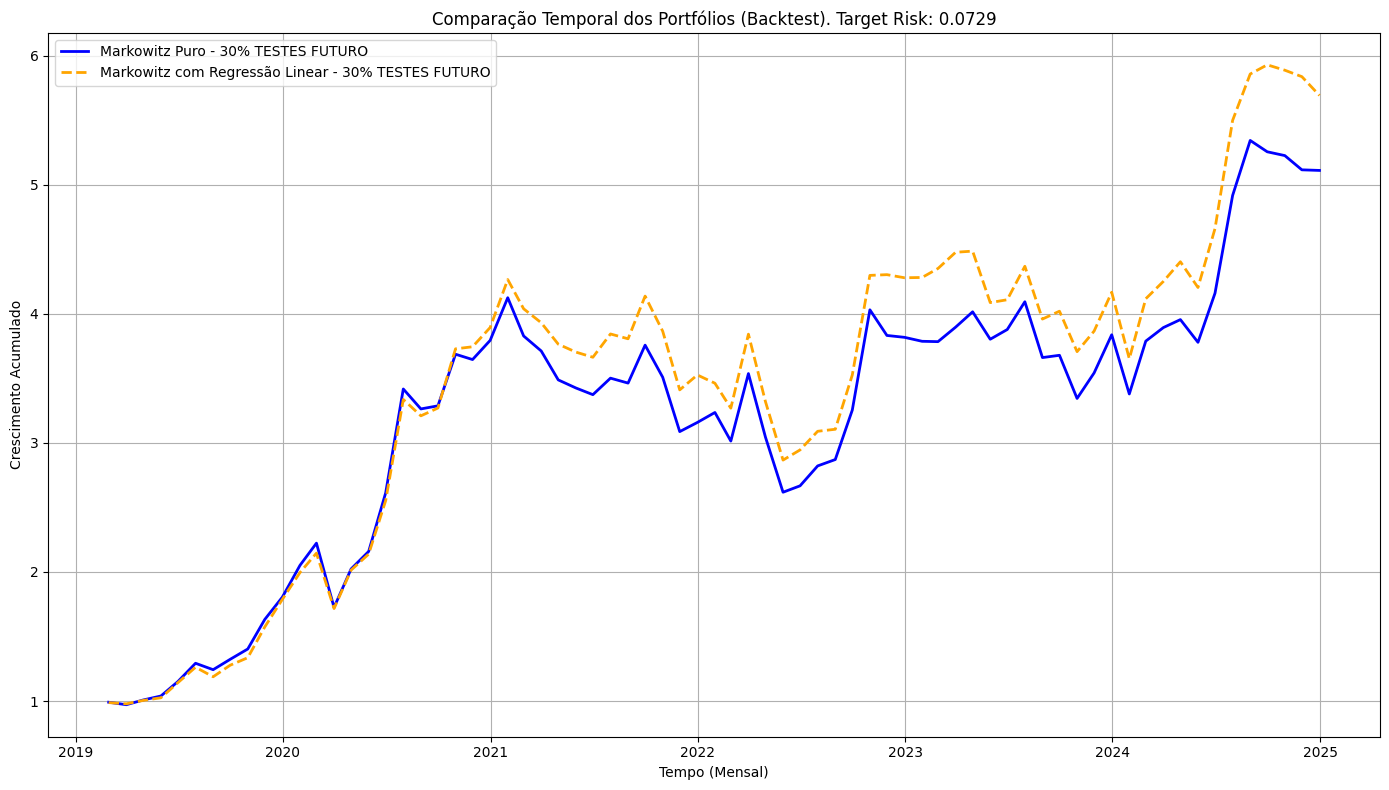

Lambda 0.09, Name: Markowitz Puro - 30% TESTES FUTURO, Volatility: 0.1010, Mean Return: 0.0306
Lambda 0.085, Name: Markowitz com Regressão Linear - 30% TESTES FUTURO, Volatility: 0.1010, Mean Return: 0.0306


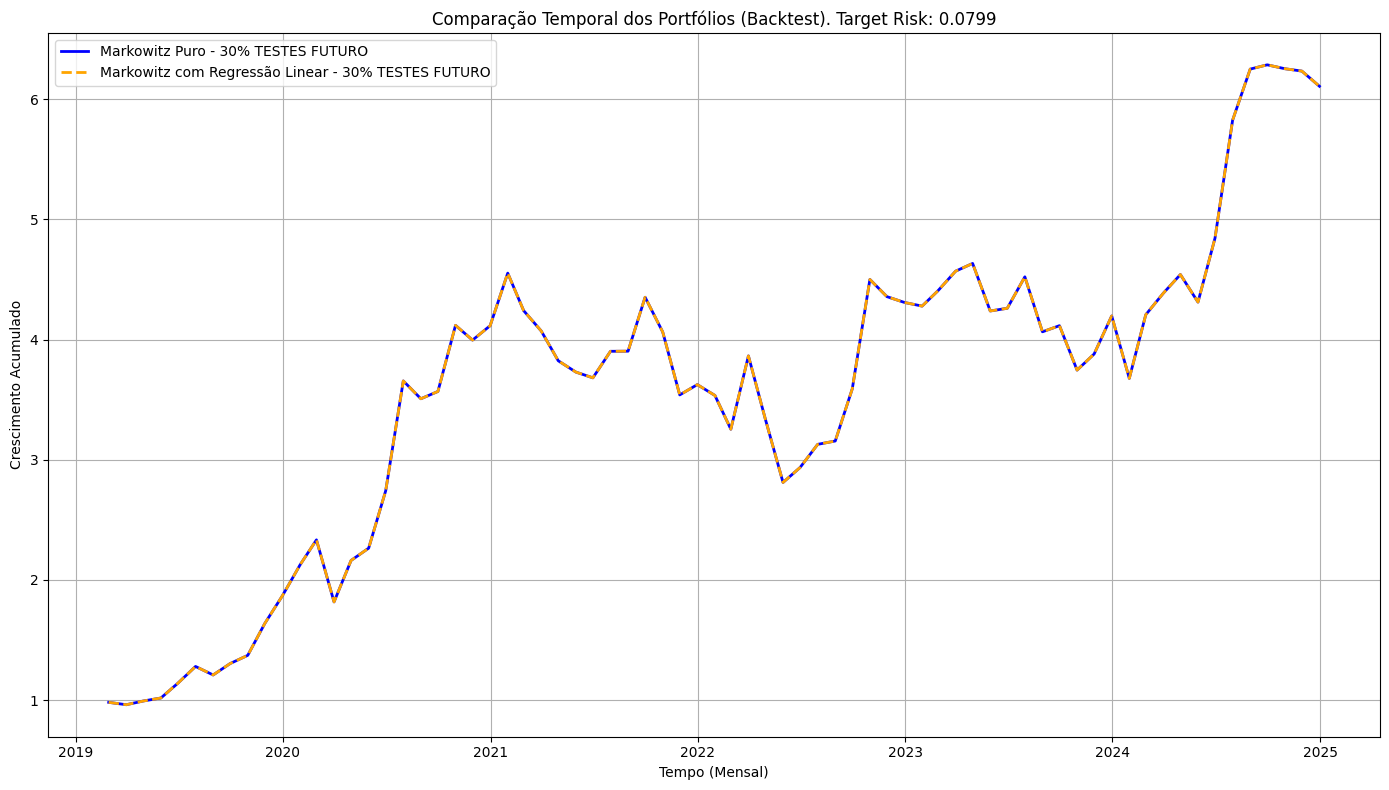

In [14]:
for target_risk in np.linspace(min_risk, max_risk, 5): 
    compare_time_series_local(models, target_risk=target_risk, w_list=w_list, lambdas=lambdas, ret_curve=ret_curve, vol_curve=vol_curve)

,Model,Mean,Volatility,Sharpe,Cumulative_Return
0,standard_markowitz,0.000687,0.013731,0.793843,2.448597
0,linear_metrics,0.000670,0.013996,0.759467,2.302013
0,rnn_metrics,0.000781,0.014041,0.882484,3.159481


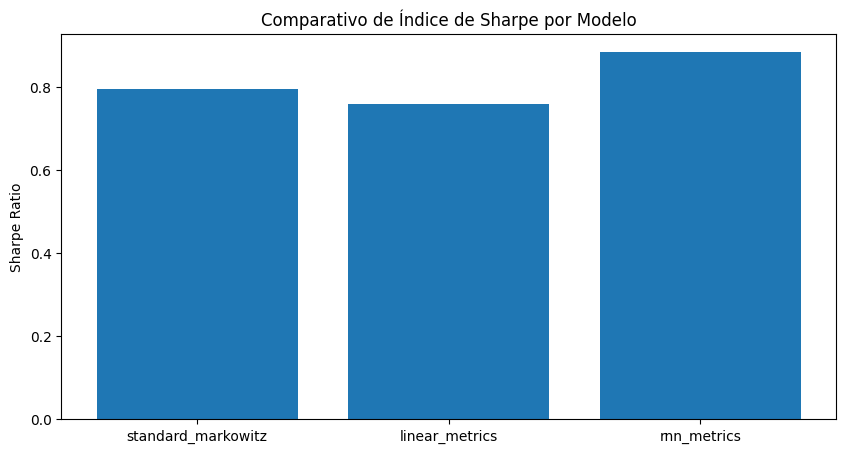

In [15]:
files = [
    "../outputs/models/standard_markowitz.csv",
    "../outputs/models/linear_metrics.csv",
    "../outputs/models/rnn_metrics.csv",
]

df_results = pd.concat([pd.read_csv(f) for f in files])
display(df_results)

plt.figure(figsize=(10, 5))
plt.bar(df_results["Model"], df_results["Sharpe"])
plt.title("Comparativo de Índice de Sharpe por Modelo")
plt.ylabel("Sharpe Ratio")
plt.show()


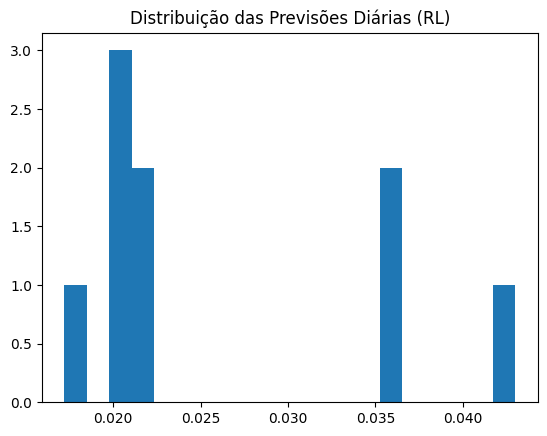

In [16]:
plt.hist(pred_montlhy, bins=20)
plt.title("Distribuição das Previsões Diárias (RL)")
plt.show()


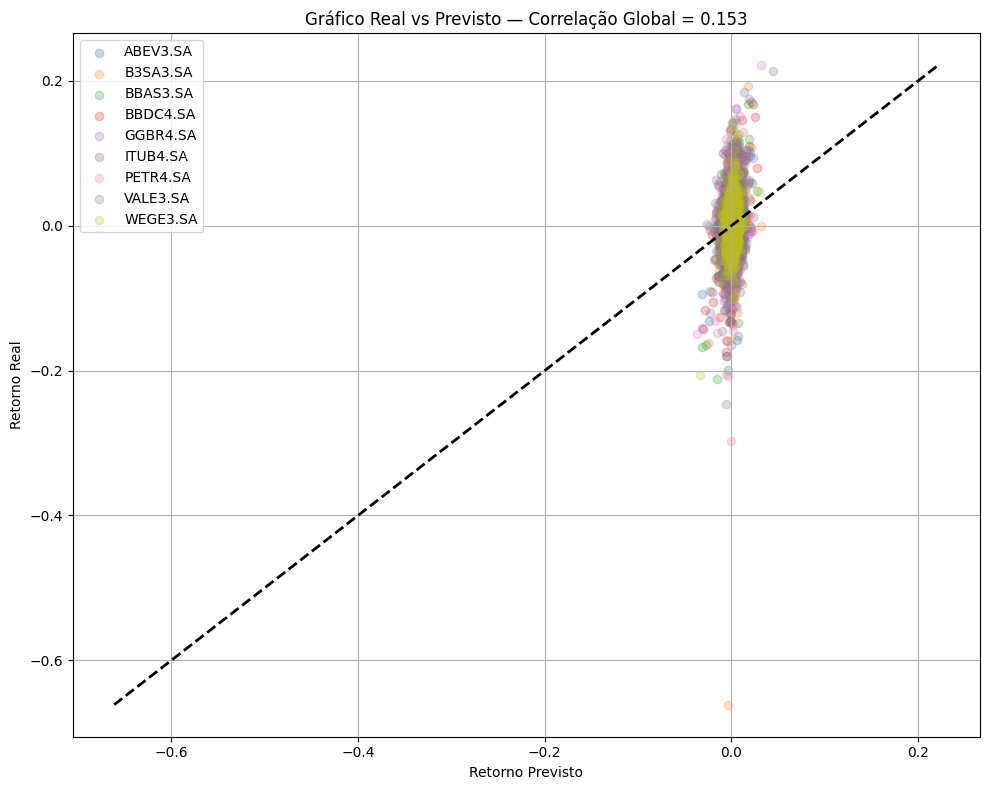

In [17]:
plot_LR_parity_return_prediction(prices, window=5)

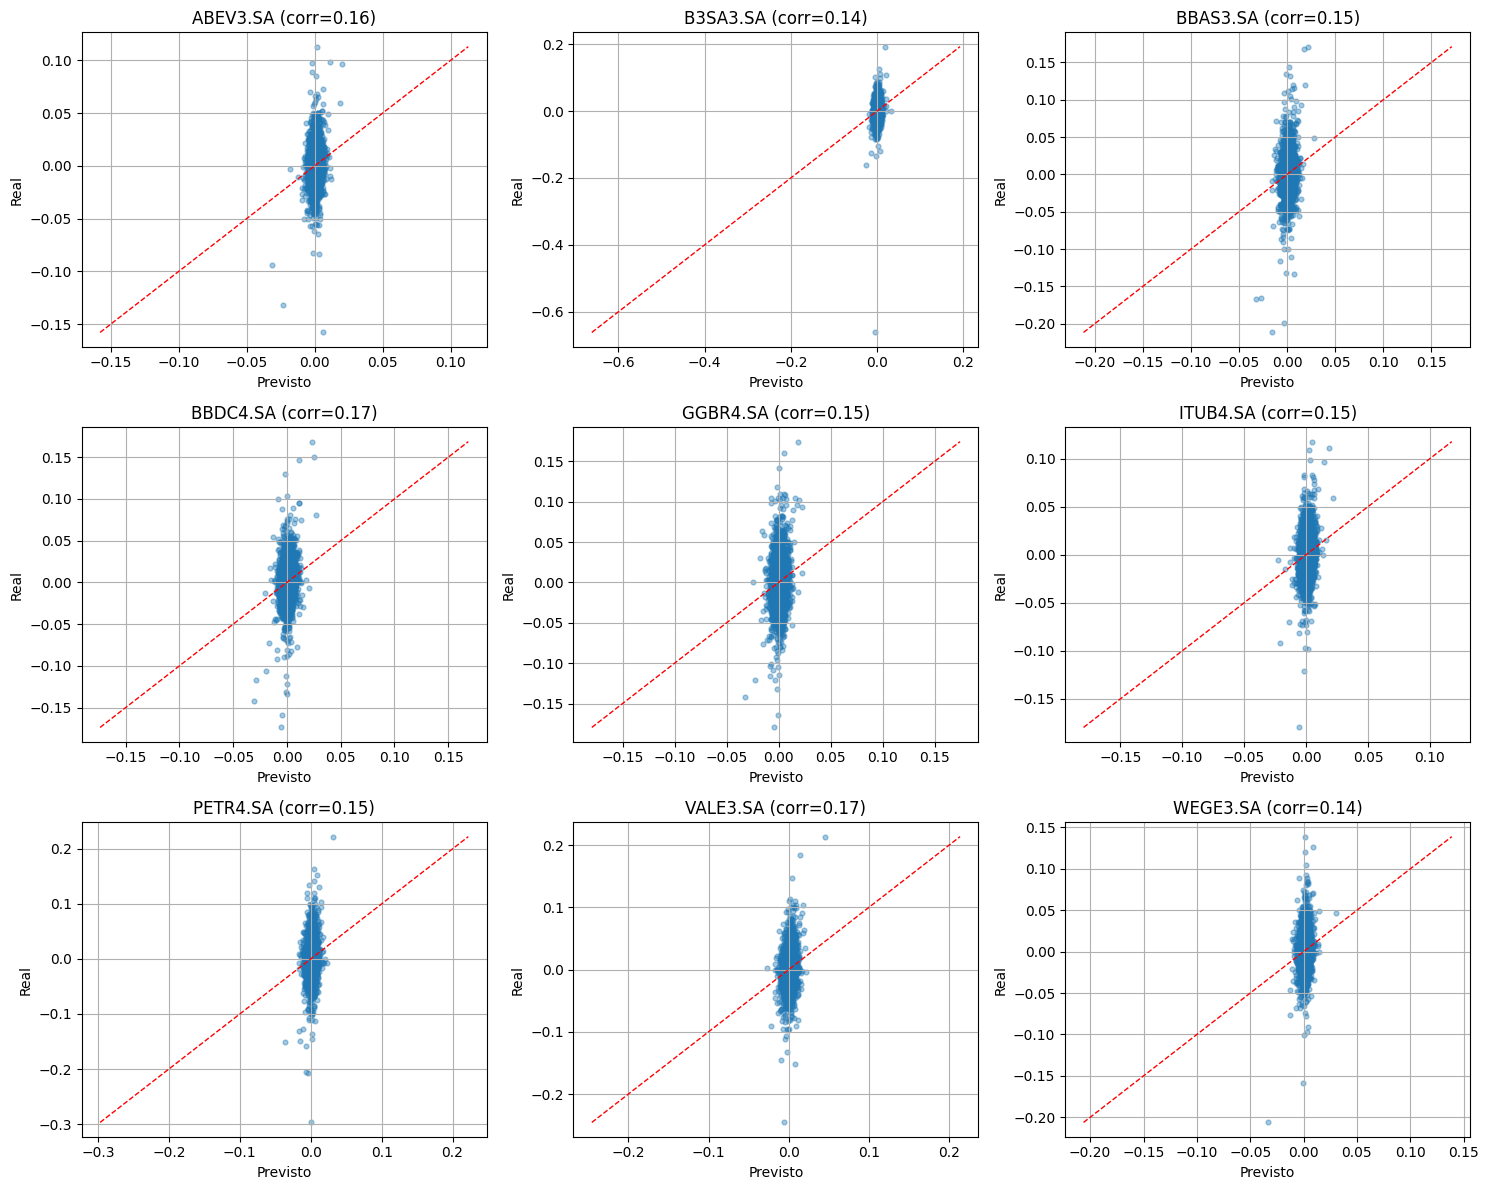

In [18]:
plot_LR_parity_by_all_assets(prices, window=5)